# Explore__Future
### A notebook to follow up on my initial explorations of outputs in `explore` and apply the techniques and visualizations to the CESM future data.
##### Initialized by Drew Camron 02/2018
---

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:50516 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
# Working directories
data_indir = (
    '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
    'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl/')

obs_indir = '/glade/p/work/jenkay/obs/COSP/CLOUDSAT/v2_Tristan/'

mask_indir = '/glade/p/work/lvank/racmo/gismask_RACMO23_0.9x1.25_con.nc'

#### Jen's dataset
Identical to dataset used in `explore`, but from a "future" CESM simulation.

In [4]:
# Reading in all years of monthly mean data
ds = xr.open_mfdataset(data_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl.cam.h0.*.nc', decode_times=False)

ds['time'] = pd.date_range('2081-01', '2090-12', freq='MS')
ds = ds.sel(lat=slice(0, 90))#.sel(time=slice('2011-01-01', '2020-12-01'))
ds

<xarray.Dataset>
Dimensions:          (cosp_dbze: 15, cosp_ht: 40, cosp_scol: 250, cosp_sr: 15, cosp_sza: 5, ilev: 31, lat: 96, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 120)
Coordinates:
  * lev              (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev             (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 ...
  * cosp_ht          (cosp_ht) float64 240.0 720.0 1.2e+03 1.68e+03 2.16e+03 ...
  * cosp_sr          (cosp_sr) float64 0.605 2.1 4.0 6.0 8.5 12.5 17.5 22.5 ...
  * cosp_sza         (cosp_sza) float64 0.0 15.0 30.0 45.0 60.0
  * cosp_scol        (cosp_scol) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * cosp_dbze        (cosp_dbze) float64 -47.5 -42.5 -37.5 -32.5 -27.5 -22.5 ...
  * lat              (lat) float64 0.4712 1.414 2.356 3.298 4.241 5.183 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * slat             (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon          

### A mean month in the data
An attempt to average all months throughout the years to get a climatological seasonal perspective. First I will definte a function to identically plot all of my desired variables. Adapted from `explore` notebook.

In [6]:
def meantime_plots(var, time, **kwargs):
    '''
    meanmonth_plots
    A work in progress function to facet out yearly averaged individual months of these CESM monthly data.
    time = 'month', 'season', etc.
    '''
    if time == 'season':
        p = (ds[var]
             .groupby('time.%s' % time)
             .mean('time')
             .sel(season=['DJF', 'MAM', 'JJA', 'SON'])
             .plot.pcolormesh(
                 transform=ccrs.PlateCarree(), col=time, vmax=100,
                 subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
        )
    
    else:
        p = (ds[var]
             .groupby('time.%s' % time)
             .mean('time')
             .plot.pcolormesh(
                 transform=ccrs.PlateCarree(), col=time, vmax=100,
                 subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
        )
    
    p.fig.suptitle('%s [%s]' % (ds[var].long_name, ds[var].units), fontsize=14, y=1.005)
    
    for ax in p.axes.flat:
        ax.coastlines()
        ax.set_extent([290, 340, 55, 85])
        
    p.fig.savefig('../figures/future/mean%s/%s.png' % (time, var))

---
Let's recreate the `explore` analysis.
* Annual mean precip/classes
* Seasonal maps 
* Seasonal cycle time series

Here I need to combine two of Jen's outputs to line up with her categories in the submitted paper.

In [7]:
RADAR_RAINLIGHT = ds['RADAR_RAINPOSS'] + ds['RADAR_RAINPROB']
RADAR_RAINLIGHT.attrs['long_name'] = 'CloudSat Radar Light Rain'
RADAR_RAINLIGHT.attrs['units'] = 'percent'

ds['RADAR_RAINLIGHT'] = RADAR_RAINLIGHT

I will plot my five categories for direct comparison, along with the other fractions of mixed or no precipitation. Also available is `RADAR_UN` uncertain precipitation fraction, but this held no information.

In [8]:
radar_vars = ['RADAR_RAINLIGHT', 'RADAR_RAINCERT', 'RADAR_RAINHARD', 'RADAR_SNOWPOSS', 'RADAR_SNOWCERT', 'RADAR_MIXPOSS', 'RADAR_MIXCERT', 'RADAR_NORAIN']

Now I will look at the annual average of these categories of precipitation.

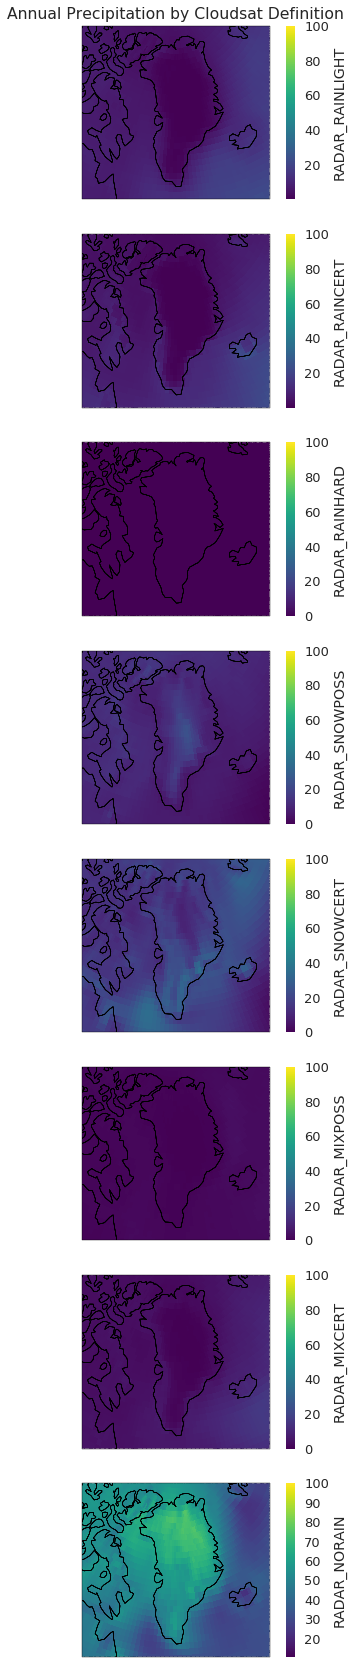

In [9]:
f, axes = plt.subplots(len(radar_vars), 1, figsize=(6, 30), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

for i, var in enumerate(radar_vars):
    p = ds[var].mean('time').plot.pcolormesh(ax=axes[i], transform=ccrs.PlateCarree(), vmax=100)
    
    for ax in axes:
        ax.coastlines()
        ax.set_extent([290, 340, 55, 85])
        
    axes[0].set_title('Annual Precipitation by Cloudsat Definition', y=1.005)

f.savefig('../figures/future/annual_maps.png')

And here I will revisit my seasonal analysis but again for each separate category of precipitation.

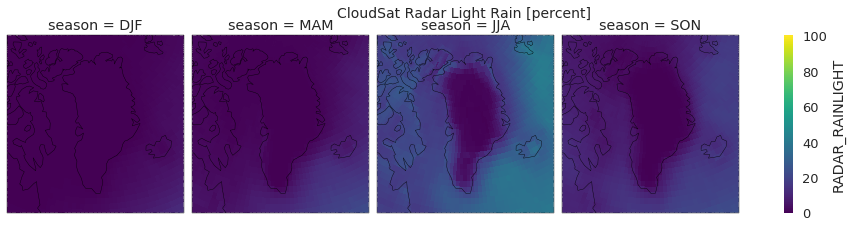

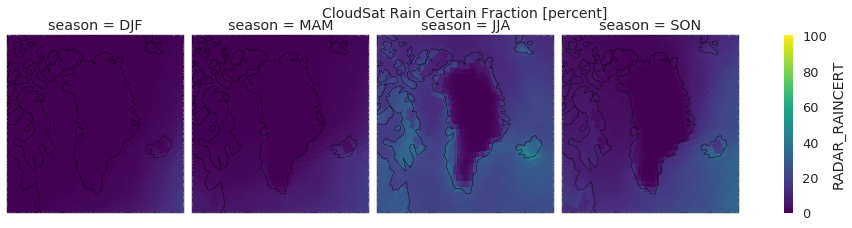

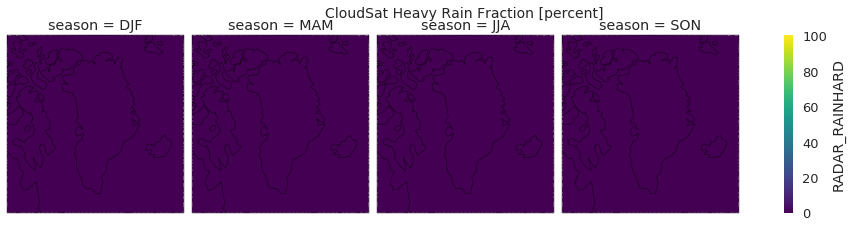

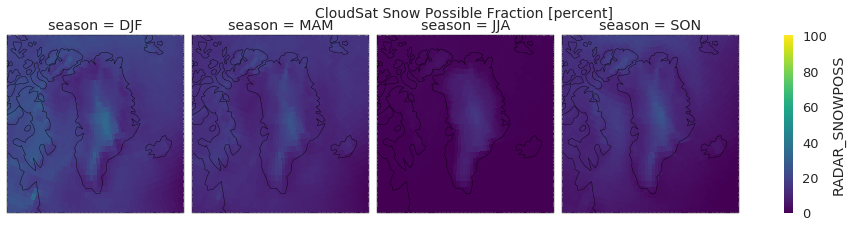

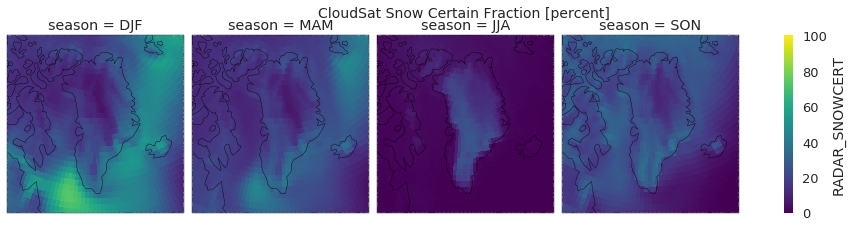

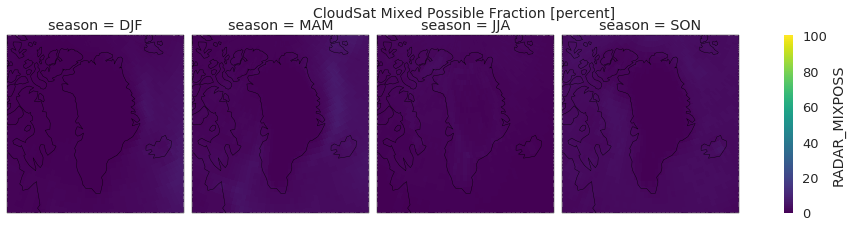

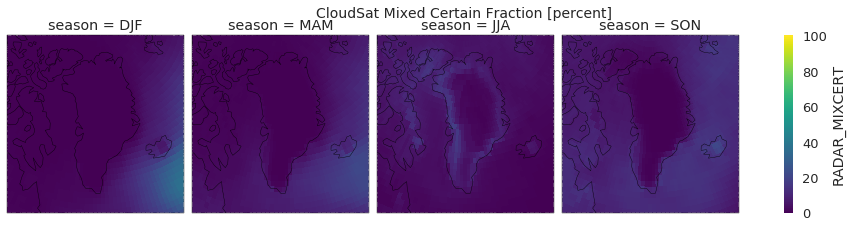

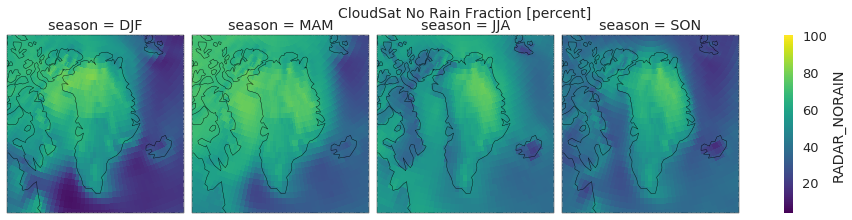

In [10]:
for var in radar_vars:
    meantime_plots(var, 'season')

Now I will read in the Jan's provided Greenland mask to take the weighted spatial average of these outputs over the Greenland ice sheet. First I will read in the mask and NaN any zero-fractions to exclude them from calculations. Afterwards I will create a weight array from the given latitude weights applied over my 1.25 deg longitude grids. **NOTE** Divide by 2.

In [11]:
ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [12]:
w = np.tile((ds['gw'][0]*1.25/360), [len(ds['lon']), 1]).T

In [13]:
ds_w = (ds[[var for var in radar_vars if var not in ('RADAR_NORAIN', 'RADAR_MIXPOSS', 'RADAR_MIXCERT')]]
        * ms.values * w).sum('lat').sum('lon') / 2

Finally, the plot of our relevant Greenland ice sheet spatially weighted average time series.

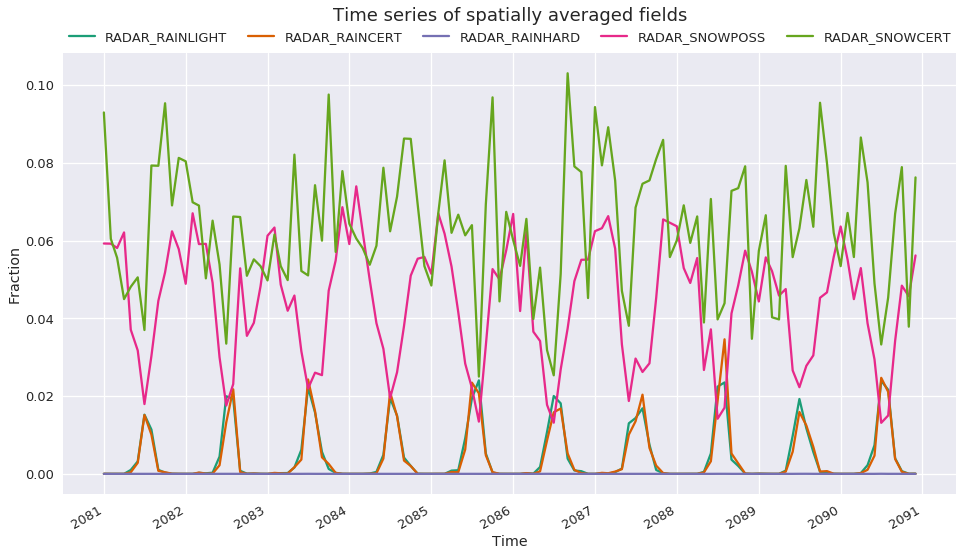

In [14]:
f, ax = plt.subplots(figsize=(16, 9))
for (i, var) in enumerate(ds_w.data_vars):
    ds_w[var].plot(ax=ax, label=('%s' % var),
                   color=sns.color_palette('Dark2', len(ds_w.data_vars))[i])
    
ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=len(ds_w.data_vars), mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Time')
ax.set_title('Time series of spatially averaged fields', y=1.06, fontsize=18)
f.savefig('../figures/future/GIS-average_tseries.png')